In [ ]:
import os
import json
import base64
import io
import zipfile
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import models, transforms, datasets
from tqdm import tqdm

# Use your existing class definitions
class CompositeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def base64_to_image(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert('L')
        image_array = np.array(image, dtype=np.float32) / 255.0
        return torch.from_numpy(image_array).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.base64_to_image(item['composite'])
        label = torch.tensor(int(item['true_digit']), dtype=torch.long)
        return image, label

class SelectionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [item for sublist in data for item in sublist]  # Flatten the list of lists

    def base64_to_image(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert('L')
        image_array = np.array(image, dtype=np.float32) / 255.0
        return torch.from_numpy(image_array).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.base64_to_image(item['selected_image'])
        label = torch.tensor(int(item['true_digit']), dtype=torch.long)
        return image, label

class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        self.class_weights = class_weights

    def forward(self, outputs, targets):
        return F.cross_entropy(outputs, targets, weight=self.class_weights)

# Sanity check functions
def load_data(test_file_path, train_file_path):
    with open(test_file_path, 'r') as f:
        test_data = json.load(f)
    
    with open(train_file_path, 'r') as f:
        train_data = json.load(f)
    
    return test_data, train_data

def create_dummy_ensemble():
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)) #PLEASE CHANGE THIS TO THE TRAINING NORMALIZATION VALUES
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')  # Convert to grayscale
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    print(f"Total training images: {len(train_images)}")
    print(f"Total test images: {len(test_images)}")
    
    for participant, data in participant_data.items():
        print(f"Participant {participant}:")
        print(f"  Training images: {len(data['train'][0])}")
        print(f"  Test images: {len(data['test'][0])}")

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

def sanity_check():
    print("Running sanity check...")
    
    # Load data
    test_data, train_data = load_data('training_data/test_set/participant_0.json', 'training_data/training_set/participant_0.json')
    
    if not test_data or not train_data:
        print("Error: Could not load data files.")
        return
    
    # Load experimental data
    exp_train_images, exp_train_labels, exp_test_images, exp_test_labels, _ = load_all_experimental_data('test_digits')
    
    # Create small datasets
    train_composite_dataset = CompositeDataset(test_data[:10])
    train_selection_dataset = SelectionDataset(train_data[:1])
    val_composite_dataset = CompositeDataset(test_data[10:20])
    exp_train_dataset = ExperimentalDataset(exp_train_images[:100], exp_train_labels[:100])
    exp_test_dataset = ExperimentalDataset(exp_test_images[:20], exp_test_labels[:20])
    
    # Create inverted MNIST dataset
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert colors
    ]))
    mnist_train_subset = torch.utils.data.Subset(mnist_train, range(100))  # Use only 100 samples for sanity check
    
    # Create data loaders
    train_composite_loader = DataLoader(train_composite_dataset, batch_size=2, shuffle=True)
    train_selection_loader = DataLoader(train_selection_dataset, batch_size=2, shuffle=True)
    val_loader = DataLoader(val_composite_dataset, batch_size=2, shuffle=False)
    exp_train_loader = DataLoader(exp_train_dataset, batch_size=2, shuffle=True)
    exp_test_loader = DataLoader(exp_test_dataset, batch_size=2, shuffle=False)
    mnist_train_loader = DataLoader(mnist_train_subset, batch_size=2, shuffle=True)
    
    # Create a dummy ensemble model
    model = create_dummy_ensemble()
    
    # Calculate class weights (considering all datasets)
    combined_dataset = ConcatDataset([train_composite_dataset, train_selection_dataset, exp_train_dataset, mnist_train_subset])
    class_weights = calculate_class_weights(combined_dataset)
    
    # Run a single epoch of training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = WeightedCrossEntropyLoss(class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    print("Training on composite images...")
    train_single_epoch(model, train_composite_loader, criterion, optimizer, device)
    
    print("Training on selection images...")
    train_single_epoch(model, train_selection_loader, criterion, optimizer, device)
    
    print("Training on experimental images...")
    train_single_epoch(model, exp_train_loader, criterion, optimizer, device)
    
    print("Training on inverted MNIST images...")
    train_single_epoch(model, mnist_train_loader, criterion, optimizer, device)
    
    print("Validating...")
    val_accuracy = evaluate_model(model, val_loader, device)
    print(f"Validation Accuracy (Composite): {val_accuracy:.2f}%")
    
    exp_accuracy = evaluate_model(model, exp_test_loader, device)
    print(f"Validation Accuracy (Experimental): {exp_accuracy:.2f}%")
    
    print("Sanity check completed successfully!")

def train_single_epoch(model, loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print("Epoch completed.")

def calculate_class_weights(dataset):
    class_counts = torch.zeros(10)
    for _, label in dataset:
        class_counts[label] += 1
    return 1.0 / (class_counts + 1e-5)  # Add small epsilon to avoid division by zero

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Run the sanity check
sanity_check()

In [ ]:
import os
import json
import base64
import io
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import models, transforms, datasets
from tqdm import tqdm

class CompositeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def base64_to_image(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert('L')
        image_array = np.array(image, dtype=np.float32) / 255.0
        return torch.from_numpy(image_array).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.base64_to_image(item['composite'])
        label = torch.tensor(int(item['true_digit']), dtype=torch.long)
        return image, label

class SelectionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [item for sublist in data for item in sublist]  # Flatten the list of lists

    def base64_to_image(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert('L')
        image_array = np.array(image, dtype=np.float32) / 255.0
        return torch.from_numpy(image_array).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.base64_to_image(item['selected_image'])
        label = torch.tensor(int(item['true_digit']), dtype=torch.long)
        return image, label

def load_data(train_folder, test_folder, num_participants=5):
    train_data = []
    for file in os.listdir(train_folder)[:num_participants]:
        with open(os.path.join(train_folder, file), 'r') as f:
            train_data.extend(json.load(f))
    
    test_data = []
    for file in os.listdir(test_folder)[:num_participants]:  # Use the same number of participants for test data
        with open(os.path.join(test_folder, file), 'r') as f:
            test_data.extend(json.load(f))
    
    return train_data, test_data

def sanity_check():
    print("Running sanity check...")
    
    # Load data
    train_data, test_data = load_data('training_data/training_set', 'training_data/test_set', num_participants=2)
    
    if not train_data or not test_data:
        print("Error: Could not load data files.")
        return
    
    print(f"Loaded {len(train_data)} training samples and {len(test_data)} test samples.")
    
    # Load experimental data
    exp_train_images, exp_train_labels, exp_test_images, exp_test_labels, _ = load_all_experimental_data('test_digits')
    
    print(f"Loaded {len(exp_train_images)} experimental training samples and {len(exp_test_images)} experimental test samples.")
    
    # Create small datasets
    train_composite_dataset = CompositeDataset(test_data[:10])
    train_selection_dataset = SelectionDataset(train_data[:1])
    val_composite_dataset = CompositeDataset(test_data[10:20])
    exp_train_dataset = ExperimentalDataset(exp_train_images[:100], exp_train_labels[:100])
    exp_test_dataset = ExperimentalDataset(exp_test_images[:20], exp_test_labels[:20])
    
    # Create inverted MNIST dataset
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert colors
    ]))
    mnist_train_subset = torch.utils.data.Subset(mnist_train, range(100))  # Use only 100 samples for sanity check
    
    # Create data loaders
    train_composite_loader = DataLoader(train_composite_dataset, batch_size=2, shuffle=True)
    train_selection_loader = DataLoader(train_selection_dataset, batch_size=2, shuffle=True)
    val_loader = DataLoader(val_composite_dataset, batch_size=2, shuffle=False)
    exp_train_loader = DataLoader(exp_train_dataset, batch_size=2, shuffle=True)
    exp_test_loader = DataLoader(exp_test_dataset, batch_size=2, shuffle=False)
    mnist_train_loader = DataLoader(mnist_train_subset, batch_size=2, shuffle=True)
    
    print("Data loaders created successfully.")
    print("Sanity check completed successfully!")

# Run the sanity check
sanity_check()

In [ ]:
import os
import json
import base64
import io
import zipfile
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Dataset, Subset
from torchvision import models, transforms, datasets
from tqdm import tqdm
import time

class CompositeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def base64_to_image(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert('L')
        image_array = np.array(image, dtype=np.float32) / 255.0
        return torch.from_numpy(image_array).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.base64_to_image(item['composite'])
        label = torch.tensor(int(item['true_digit']), dtype=torch.long)
        return image, label

class SelectionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [item for sublist in data for item in sublist]  # Flatten the list of lists

    def base64_to_image(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert('L')
        image_array = np.array(image, dtype=np.float32) / 255.0
        return torch.from_numpy(image_array).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.base64_to_image(item['selected_image'])
        label = torch.tensor(int(item['true_digit']), dtype=torch.long)
        return image, label

class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        self.class_weights = class_weights

    def forward(self, outputs, targets):
        return F.cross_entropy(outputs, targets, weight=self.class_weights)

def load_data(train_folder, test_folder, num_participants=100):
    train_data = []
    for file in os.listdir(train_folder)[:num_participants]:
        with open(os.path.join(train_folder, file), 'r') as f:
            train_data.extend(json.load(f))
    
    test_data = []
    for file in os.listdir(test_folder)[:num_participants]:
        with open(os.path.join(test_folder, file), 'r') as f:
            test_data.extend(json.load(f))
    
    return train_data, test_data

def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')  # Convert to grayscale
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

def create_ensemble():
    model = models.resnet50(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

def calculate_class_weights(dataset):
    class_counts = torch.zeros(10)
    for _, label in dataset:
        class_counts[label] += 1
    return 1.0 / (class_counts + 1e-5)

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_model(model, train_loaders, val_loaders, criterion, optimizer, scheduler, num_epochs, device, save_dir):
    best_val_acc = 0
    start_time = time.time()
    last_save_time = start_time
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        model.train()
        for phase, loader in train_loaders.items():
            running_loss = 0.0
            correct = 0
            total = 0
            
            progress_bar = tqdm(loader, desc=f"Training on {phase}")
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': 100 * correct / total})
            
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = 100 * correct / total
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%")
        
        # Validation step
        model.eval()
        val_acc = {}
        for phase, loader in val_loaders.items():
            acc = evaluate_model(model, loader, device)
            val_acc[phase] = acc
            print(f"Validation Accuracy ({phase}): {acc:.2f}%")
        
        # Save the best model
        if val_acc['composite'] > best_val_acc:
            best_val_acc = val_acc['composite']
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"Saved new best model with validation accuracy: {best_val_acc:.2f}%")
        
        # Periodic saving (every hour)
        current_time = time.time()
        if current_time - last_save_time > 3600:  # 3600 seconds = 1 hour
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch}.pth'))
            print(f"Saved periodic checkpoint at epoch {epoch}")
            last_save_time = current_time
        
        scheduler.step(val_acc['composite'])
        
        # Check if we've reached 36 hours
        if current_time - start_time > 36 * 3600:
            print("Reached 36 hours of training. Stopping.")
            break
    
    # Save final model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc,
    }, os.path.join(save_dir, 'final_model.pth'))
    print("Saved final model")
    
    return model

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load all datasets
    train_data, test_data = load_data('training_data/training_set', 'training_data/test_set', num_participants=100)
    exp_train_images, exp_train_labels, exp_test_images, exp_test_labels, _ = load_all_experimental_data('test_digits')
    
    # Create datasets
    train_composite_dataset = CompositeDataset(test_data)
    train_selection_dataset = SelectionDataset(train_data)
    exp_train_dataset = ExperimentalDataset(exp_train_images, exp_train_labels)
    exp_test_dataset = ExperimentalDataset(exp_test_images, exp_test_labels)
    
    # Create inverted MNIST dataset
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert colors
    ]))
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert colors
    ]))

    # Create data loaders
    train_loaders = {
        'composite': DataLoader(train_composite_dataset, batch_size=64, shuffle=True, num_workers=4),
        'selection': DataLoader(train_selection_dataset, batch_size=64, shuffle=True, num_workers=4),
        'experimental': DataLoader(exp_train_dataset, batch_size=64, shuffle=True, num_workers=4),
        'mnist': DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=4)
    }
    
    val_loaders = {
        'composite': DataLoader(CompositeDataset(test_data[-1000:]), batch_size=64, shuffle=False, num_workers=4),
        'experimental': DataLoader(exp_test_dataset, batch_size=64, shuffle=False, num_workers=4),
        'mnist': DataLoader(mnist_test, batch_size=64, shuffle=False, num_workers=4)
    }

    model = create_ensemble().to(device)

    combined_dataset = ConcatDataset([train_composite_dataset, train_selection_dataset, exp_train_dataset, mnist_train])
    class_weights = calculate_class_weights(combined_dataset).to(device)

    criterion = WeightedCrossEntropyLoss(class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    save_dir = 'model_36_hours'
    trained_model = train_model(model, train_loaders, val_loaders, criterion, optimizer, scheduler, num_epochs=1000, device=device, save_dir=save_dir)

    print("Training completed.")

if __name__ == "__main__":
    main()

This ran for 3200 and was just frozen, didn't do much of anything. Making a 4 hour version instead.

In [1]:
import os
import json
import base64
import io
import zipfile
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Dataset, Subset
from torchvision import models, transforms, datasets
from tqdm import tqdm
import time

In [ ]:
class CompositeDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def base64_to_image(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert('L')
        image_array = np.array(image, dtype=np.float32) / 255.0
        return torch.from_numpy(image_array).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.base64_to_image(item['composite'])
        label = torch.tensor(int(item['true_digit']), dtype=torch.long)
        return image, label

class SelectionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [item for sublist in data for item in sublist]  # Flatten the list of lists

    def base64_to_image(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert('L')
        image_array = np.array(image, dtype=np.float32) / 255.0
        return torch.from_numpy(image_array).unsqueeze(0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.base64_to_image(item['selected_image'])
        label = torch.tensor(int(item['true_digit']), dtype=torch.long)
        return image, label

class ExperimentalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        self.class_weights = class_weights

    def forward(self, outputs, targets):
        return F.cross_entropy(outputs, targets, weight=self.class_weights)

def load_data(train_folder, test_folder, num_participants=100):
    train_data = []
    for file in os.listdir(train_folder)[:num_participants]:
        with open(os.path.join(train_folder, file), 'r') as f:
            train_data.extend(json.load(f))
    
    test_data = []
    for file in os.listdir(test_folder)[:num_participants]:
        with open(os.path.join(test_folder, file), 'r') as f:
            test_data.extend(json.load(f))
    
    return train_data, test_data

def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')  # Convert to grayscale
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

In [ ]:
def train_model(model, train_loaders, val_loaders, criterion, optimizer, scheduler, num_epochs, device, save_dir):
    best_val_acc = 0
    start_time = time.time()
    last_save_time = start_time

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        model.train()
        for phase, loader in train_loaders.items():
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm(loader, desc=f"Training on {phase}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = 100 * correct / total
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%")

        # Validation step
        model.eval()
        val_acc = {}
        for phase, loader in val_loaders.items():
            acc = evaluate_model(model, loader, device)
            val_acc[phase] = acc
            print(f"Validation Accuracy ({phase}): {acc:.2f}%")

        # Save the best model
        if val_acc['composite'] > best_val_acc:
            best_val_acc = val_acc['composite']
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"Saved new best model with validation accuracy: {best_val_acc:.2f}%")

        # Periodic saving (every hour)
        current_time = time.time()
        if current_time - last_save_time > 3600:  # 3600 seconds = 1 hour
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch}.pth'))
            print(f"Saved periodic checkpoint at epoch {epoch}")
            last_save_time = current_time

        scheduler.step(val_acc['composite'])

        # Print time elapsed
        time_elapsed = time.time() - start_time
        print(f"Time elapsed: {time_elapsed / 3600:.2f} hours")

    # Save final model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc,
    }, os.path.join(save_dir, 'final_model.pth'))
    print("Saved final model")

    return model

In [ ]:
def calculate_class_weights(dataset):
    class_counts = torch.zeros(10)
    for _, label in dataset:
        class_counts[label] += 1
    return 1.0 / (class_counts + 1e-5)

def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def create_ensemble():
    model = models.resnet50(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

class CompositeDataset(Dataset):
    def __init__(self, data, max_samples=None, transform=None):
        self.data = data[:max_samples] if max_samples else data
        self.transform = transform or transforms.Compose([
            transforms.Resize((16, 16)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = self.load_image(item['composite'])
        label = torch.tensor(int(item['true_digit']), dtype=torch.long)
        return image, label

    def load_image(self, base64_string):
        image_data = base64.b64decode(base64_string)
        image = Image.open(io.BytesIO(image_data)).convert('L')
        image = self.transform(image)
        return image

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load a subset of the data
    train_data, test_data = load_data('training_data/training_set', 'training_data/test_set', num_participants=20)  # Reduced from 100 to 20
    exp_train_images, exp_train_labels, exp_test_images, exp_test_labels, _ = load_all_experimental_data('test_digits')

    # Create datasets
    #train_composite_dataset = CompositeDataset(test_data[:1000])  # Use only the first 1000 samples
    max_samples = 1000  # Adjust this number based on your available memory and desired dataset size
    train_composite_dataset = CompositeDataset(test_data, max_samples=max_samples)
    train_selection_dataset = SelectionDataset(train_data[:1000])  # Use only the first 1000 samples
    exp_train_dataset = ExperimentalDataset(exp_train_images[:1000], exp_train_labels[:1000])  # Use only the first 1000 samples

    # Create inverted MNIST dataset (use a subset)
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert colors
    ]))
    mnist_train_subset = Subset(mnist_train, range(1000))  # Use only the first 1000 samples

    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert colors
    ]))
    mnist_test_subset = Subset(mnist_test, range(1000))  # Use only the first 1000 samples

    # Create data loaders with smaller batch size and fewer workers
    train_loaders = {
        'composite': DataLoader(train_composite_dataset, batch_size=32, shuffle=True, num_workers=2),
        'selection': DataLoader(train_selection_dataset, batch_size=32, shuffle=True, num_workers=2),
        'experimental': DataLoader(exp_train_dataset, batch_size=32, shuffle=True, num_workers=2),
        'mnist': DataLoader(mnist_train_subset, batch_size=32, shuffle=True, num_workers=2)
    }
    val_loaders = {
        'composite': DataLoader(CompositeDataset(test_data[-500:]), batch_size=32, shuffle=False, num_workers=2),
        'experimental': DataLoader(ExperimentalDataset(exp_test_images[:500], exp_test_labels[:500]), batch_size=32, shuffle=False, num_workers=2),
        'mnist': DataLoader(mnist_test_subset, batch_size=32, shuffle=False, num_workers=2)
    }

    # Use a smaller ResNet model
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    model = model.to(device)

    combined_dataset = ConcatDataset([train_composite_dataset, train_selection_dataset, exp_train_dataset, mnist_train_subset])
    class_weights = calculate_class_weights(combined_dataset).to(device)
    criterion = WeightedCrossEntropyLoss(class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    save_dir = 'model_checkpoints'
    trained_model = train_model(model, train_loaders, val_loaders, criterion, optimizer, scheduler, num_epochs=50, device=device, save_dir=save_dir)
    print("Training completed.")

if __name__ == "__main__":
    main()

Using device: cuda


c:\Users\Sai\Desktop\NN_digit_classifier\Southampton_NN_digit_classifier\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sai\Desktop\NN_digit_classifier\Southampton_NN_digit_classifier\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Sai\Desktop\NN_digit_classifier\Southampton_NN_digit_classifier\env\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/50
----------


Training on composite:   0%|          | 0/32 [00:00<?, ?it/s]

: 

: 

this just keeps getting stuck without actually running anything or making me anything which absolutely sucks. What we are going to do is try to run a different model without as much data at the same time. 

In [6]:
import os
import json
import base64
import io
import zipfile
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Dataset, Subset
from torchvision import models, transforms, datasets
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [9]:
def add_noise(x, noise_factor=0.1):
    noisy = x + torch.randn_like(x) * noise_factor
    return torch.clamp(noisy, 0., 1.)

def invert_colors(x):
    return 1 - x

def visualize_datasets(mnist_train, mnist_noisy_train, exp_train_dataset, num_samples=5):
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    
    datasets = [
        ("MNIST (Inverted)", mnist_train),
        ("MNIST Noisy (Inverted)", mnist_noisy_train),
        ("Experimental", exp_train_dataset)
    ]
    
    for i, (name, dataset) in enumerate(datasets):
        for j in range(num_samples):
            if name == "Experimental":
                image, label = dataset[j]
            else:
                image, label = dataset[j]
                image = invert_colors(image) if "Inverted" in name else image
                if "Noisy" in name:
                    image = add_noise(image)
            
            ax = axes[i][j]
            ax.imshow(image.squeeze(), cmap='gray')
            ax.set_title(f"{name}: {label}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('dataset_samples.png')
    plt.close()
    print("Dataset samples saved as 'dataset_samples.png'")

def create_model():
    model = models.resnet50(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

def train_model(model, train_loaders, val_loaders, criterion, optimizer, scheduler, num_epochs, device, save_dir):
    best_val_acc = 0
    start_time = time.time()
    last_save_time = start_time

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        model.train()
        for phase, loader in train_loaders.items():
            running_loss = 0.0
            correct = 0
            total = 0
            progress_bar = tqdm(loader, desc=f"Training on {phase}")
            for batch_idx, (inputs, labels) in enumerate(progress_bar):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                if batch_idx % 10 == 0:  # Update every 10 batches
                    progress_bar.set_postfix({
                        'Loss': loss.item(),
                        'Accuracy': 100 * correct / total,
                        'LR': optimizer.param_groups[0]['lr']
                    })

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = 100 * correct / total
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%")

        # Validation step
        model.eval()
        val_acc = {}
        for phase, loader in val_loaders.items():
            acc = evaluate_model(model, loader, device)
            val_acc[phase] = acc
            print(f"Validation Accuracy ({phase}): {acc:.2f}%")

        # Save the best model
        if val_acc['mnist'] > best_val_acc:
            best_val_acc = val_acc['mnist']
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"Saved new best model with validation accuracy: {best_val_acc:.2f}%")

        # Periodic saving (every hour)
        current_time = time.time()
        if current_time - last_save_time > 3600:  # 3600 seconds = 1 hour
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch}.pth'))
            print(f"Saved periodic checkpoint at epoch {epoch}")
            last_save_time = current_time

        scheduler.step(val_acc['mnist'])

        # Print time elapsed
        time_elapsed = (time.time() - start_time) / 3600  # in hours
        print(f"Time elapsed: {time_elapsed:.2f} hours")

    # Save final model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc,
    }, os.path.join(save_dir, 'final_model.pth'))
    print("Saved final model")

    return model

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

def add_noise(image, noise_factor=0.5):
    # Convert image to range [0, 1]
    image = image * 0.3081 + 0.1307  # Reverse the normalization
    
    # Add noise
    noise = torch.randn(image.size()) * noise_factor
    noisy_image = image + noise
    
    # Clip to ensure values are in [0, 1]
    noisy_image = torch.clamp(noisy_image, 0., 1.)
    
    # Renormalize
    noisy_image = (noisy_image - 0.1307) / 0.3081
    
    return noisy_image

class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, noise_factor=0.5):
        self.mnist_dataset = mnist_dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        noisy_image = add_noise(image, self.noise_factor)
        return noisy_image, label

def load_noisy_mnist_data(train=True, noise_factor=0.5):
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert colors
    ])
    mnist_dataset = datasets.MNIST(root='./data', train=train, download=True, transform=transform)
    noisy_dataset = NoisyMNISTDataset(mnist_dataset, noise_factor)
    return noisy_dataset

def visualize_datasets(mnist_train, mnist_noisy_train, exp_train_dataset, num_samples=5):
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    
    datasets = [
        ("MNIST", mnist_train),
        ("MNIST Noisy", mnist_noisy_train),
        ("Experimental", exp_train_dataset)
    ]
    
    for i, (name, dataset) in enumerate(datasets):
        for j in range(num_samples):
            image, label = dataset[j]
            
            # Denormalize the image for visualization
            image = image * 0.3081 + 0.1307
            
            ax = axes[i][j]
            ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)
            ax.set_title(f"{name}: {label}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('dataset_samples.png')
    plt.close()
    print("Dataset samples saved as 'dataset_samples.png'")

In [24]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load experimental data
    exp_train_images, exp_train_labels, exp_test_images, exp_test_labels, _ = load_all_experimental_data('test_digits')

    # Create MNIST dataset
    mnist_transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

    # Create noisy MNIST dataset
    mnist_noisy_train = NoisyMNISTDataset(mnist_train, noise_factor=0.5)
    mnist_noisy_test = NoisyMNISTDataset(mnist_test, noise_factor=0.5)

    # Create inverted MNIST dataset
    invert_transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert colors
    ])
    mnist_inverted_train = datasets.MNIST(root='./data', train=True, download=True, transform=invert_transform)
    mnist_inverted_test = datasets.MNIST(root='./data', train=False, download=True, transform=invert_transform)

    # Visualize samples from each dataset
    visualize_datasets(mnist_inverted_train, mnist_noisy_train, ExperimentalDataset(exp_train_images, exp_train_labels))

    # Wait for user input before proceeding
    input("Press Enter to start training after reviewing the dataset samples...")

    # Create data loaders
    train_loaders = {
        'mnist_inverted': DataLoader(mnist_inverted_train, batch_size=64, shuffle=True, num_workers=4),
        'mnist_noisy': DataLoader(mnist_noisy_train, batch_size=64, shuffle=True, num_workers=4),
        'experimental': DataLoader(ExperimentalDataset(exp_train_images, exp_train_labels), batch_size=64, shuffle=True, num_workers=4)
    }
    val_loaders = {
        'mnist_inverted': DataLoader(mnist_inverted_test, batch_size=64, shuffle=False, num_workers=4),
        'mnist_noisy': DataLoader(mnist_noisy_test, batch_size=64, shuffle=False, num_workers=4),
        'experimental': DataLoader(ExperimentalDataset(exp_test_images, exp_test_labels), batch_size=64, shuffle=False, num_workers=4)
    }

    model = create_model().to(device)

    combined_dataset = ConcatDataset([mnist_inverted_train, mnist_noisy_train, ExperimentalDataset(exp_train_images, exp_train_labels)])
    class_weights = calculate_class_weights(combined_dataset).to(device)
    criterion = WeightedCrossEntropyLoss(class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    save_dir = 'model_50_epochs'
    num_epochs = 50

    print("Starting training...")
    trained_model = train_model(model, train_loaders, val_loaders, criterion, optimizer, scheduler, num_epochs, device, save_dir)
    print("Training completed.")

if __name__ == "__main__":
    main()

Using device: cuda
Dataset samples saved as 'dataset_samples.png'


KeyboardInterrupt: 

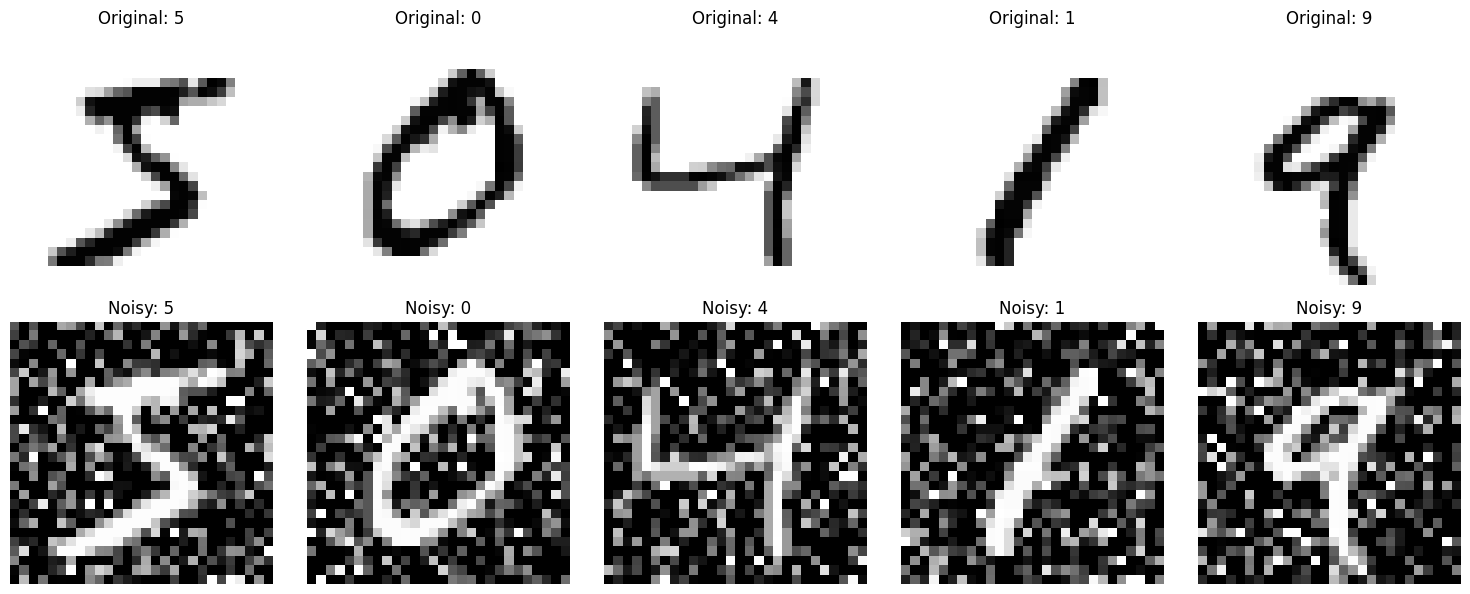

In [26]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

def add_background_noise(image, noise_factor=0.5):
    # Invert the image (black digits on white background)
    image = 1 - image
    
    # Create a noise mask (1 for background, 0 for digit)
    mask = (image > 0.7).float()
    
    # Generate noise
    noise = torch.randn_like(image) * noise_factor
    
    # Apply noise only to the background
    noisy_image = image + noise * mask
    
    # Clip to ensure values are in [0, 1]
    noisy_image = torch.clamp(noisy_image, 0., 1.)
    
    return noisy_image

def visualize_noisy_mnist(num_samples=5):
    # Load MNIST dataset
    mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                             transform=transforms.ToTensor())
    
    # Create a figure
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(num_samples):
        # Get a sample image
        image, label = mnist_train[i]
        
        # Add noise to the image
        noisy_image = add_background_noise(image)
        
        # Display original image (inverted)
        axes[0, i].imshow(1 - image.squeeze(), cmap='gray')
        axes[0, i].set_title(f"Original: {label}")
        axes[0, i].axis('off')
        
        # Display noisy image
        axes[1, i].imshow(1 - noisy_image.squeeze(), cmap='gray')
        axes[1, i].set_title(f"Noisy: {label}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_noisy_mnist()